In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.data_manager import NpzFilesCollector

%matplotlib inline

TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats'

## Load simulation data

In [2]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

try:
    STATS = np.load(STATS_PATH)
except:
    STATS = NpzFilesCollector(STATS_PATH)
with STATS:
    summ_stats = STATS['x']
    labels = STATS['y']
    ys = STATS['ys']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


#### Summary statistics names

In [3]:
summ_stats_names = np.array([
    'avg_mean', 'avg_std', 'avg_max_idx_x', 'avg_max_idx_y', 'avg_max_val', 'avg_min_idx_x', 'avg_min_idx_y', 'avg_min_val',
    't_tr_mean', 't_tr_std', 't_tr_max_idx_x', 't_tr_max_idx_y', 't_tr_max_val', 't_tr_min_idx_x', 't_tr_min_idx_y', 't_tr_min_val',
    't_pk_mean', 't_pk_std', 't_pk_max_idx_x', 't_pk_max_idx_y', 't_pk_max_val', 't_pk_min_idx_x', 't_pk_min_idx_y', 't_pk_min_val',
    'stdev_mean', 'stdev_std', 'stdev_max_idx_x', 'stdev_max_idx_y', 'stdev_max_val',
    'tr_mean', 'tr_std', 'tr_max_idx_x', 'tr_max_idx_y', 'tr_max_val',
    'pk_mean', 'pk_std', 'pk_max_idx_x', 'pk_max_idx_y', 'pk_max_val',
    't0', 't1', 't2', 't0_half_l_idx_y', 't0_half_r_idx_y', 't2_half_l_idx_y', 't2_half_r_idx_y', 't1_max_idx_y', 't1_min_idx_y',
    'tr_lambda_l', 'tr_lambda_r', 'tr_slope_l', 'tr_slope_r',
    'pk_lambda_l', 'pk_lambda_r', 'pk_slope_l', 'pk_slope_r',
    'tr_l_w1', 'tr_l_w2', 'tr_l_y1', 'tr_r_w1', 'tr_r_w2', 'tr_r_y1',
    'pk_l_w1', 'pk_l_w2', 'pk_l_y1', 'pk_r_w1', 'pk_r_w2', 'pk_r_y1',
    'tr_l_avg_mag', 'tr_r_avg_mag', 'pk_l_avg_mag', 'pk_r_avg_mag'
])

### Transform labels

#### Orientation

In [4]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [5]:
has_yshift = 'y' in label_list and ys.size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = ys
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0],inplace=True)

with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
507,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
2419,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
1227,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
2899,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
2187,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
...,...,...,...,...,...,...,...
4650,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499
1547,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499
2267,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499
3939,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499


### Normalizing labels

#### Set bounds for y shift

In [6]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))

print(json.dumps(ranges))

0.15% outside bounds.
{"x": [-50, 50], "y": [-750.0, 750.0], "z": [50.0, 200.0], "alpha": [0, 3.141592653589793], "h": [0.7071, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [50.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "l_t": [100.0, 1200.0], "lr_pt": [0.02, 0.35], "r_t": [0.4, 1.5], "rr_dt": [0.4, 0.8], "ys": [-150, 150]}


#### Normalization

In [7]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
0,-0.096100,0.273923,-0.835357,0.879617,-0.239984,0.137487,0.538365
1,-0.163525,-0.460427,-0.285975,0.879617,-0.239984,0.137487,0.538365
2,-0.009170,-0.918053,-0.063370,0.879617,-0.239984,0.137487,0.538365
3,-0.012605,-0.966945,0.505476,0.879617,-0.239984,0.137487,0.538365
4,-0.402007,0.626540,0.053581,0.879617,-0.239984,0.137487,0.538365
...,...,...,...,...,...,...,...
5970,0.267354,0.157517,0.160416,-0.670273,0.044492,-0.776285,-0.091402
5971,0.187734,-0.605530,0.050717,-0.670273,0.044492,-0.776285,-0.091402
5972,0.149978,0.616274,-0.211914,-0.670273,0.044492,-0.776285,-0.091402
5973,0.125903,-0.022308,-0.038586,-0.670273,0.044492,-0.776285,-0.091402


## Build and train model

In [8]:
train_size = 0.8
summ_stats_train, summ_stats_test, labels_train, labels_test = train_test_split(
    summ_stats, labels, train_size=train_size, random_state=0)

model = RandomForestRegressor()
model.fit(summ_stats_train, labels_train)

RandomForestRegressor()

### Evaluate model

In [9]:
from sklearn.metrics import r2_score, mean_squared_error

y = labels_test.copy()
output = model.predict(summ_stats_test)
rmse = mean_squared_error(y, output, squared=False)
print(f'RMSE: {rmse: .4g}')

# back to original scale
for i, lb in enumerate(label_list):
    y[:, i] = org_scale(y[:, i], ranges[lb])
    output[:, i] = org_scale(output[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

RMSE:  0.03522
R2 Score:
y-shift,   0.994
d,         0.999
theta,     0.992
l_t,       0.997
lr_pt,     0.991
r_t,       0.998
rr_dt,     0.984


Stylized Cell Testing Data: Ground Truth VS Predicted


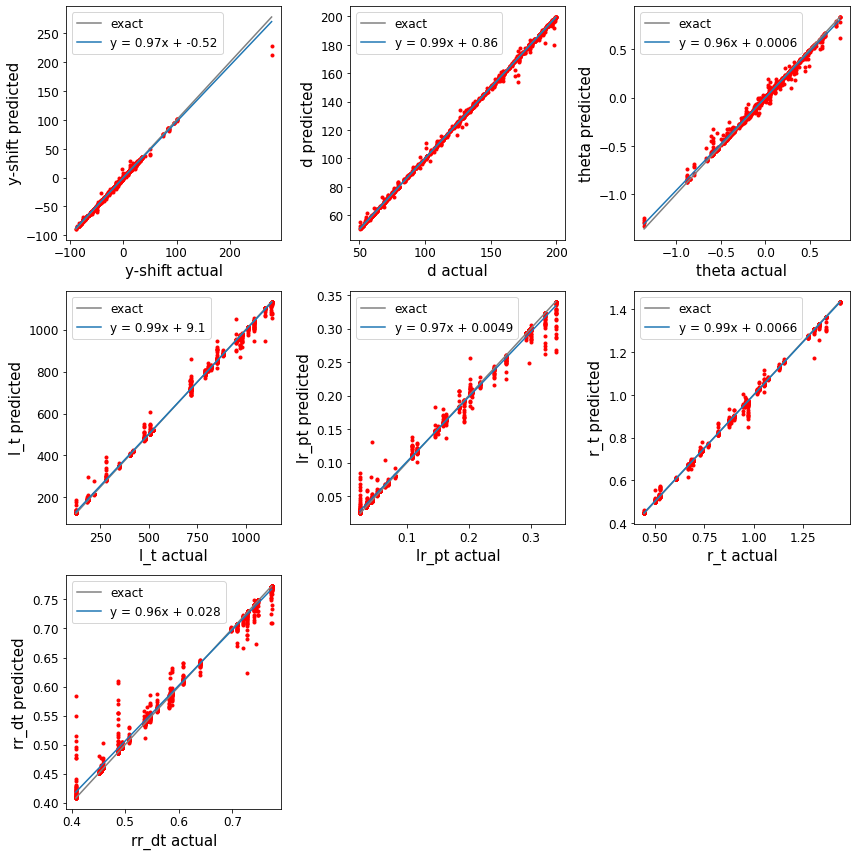

In [10]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

fig = plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:, i], output[:, i], c='red', marker='.')
    m, b = np.polyfit(y[:, i], output[:, i], 1)
    yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
    ax.plot(yl, yl, color='gray', label='exact')
    ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

### Feature importance

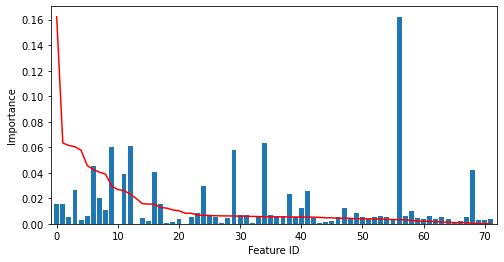

In [11]:
feat_df = pd.DataFrame({'id': range(model.n_features_in_), 'importance': model.feature_importances_,
                        'feature': summ_stats_names[:model.n_features_in_]})
feat_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

plt.figure(figsize=(8, 4))
plt.bar(feat_df['id'], feat_df['importance'])
plt.plot(feat_df['importance'].values, 'r')
plt.xlim(-1, len(feat_df))
plt.xlabel('Feature ID')
plt.ylabel('Importance')
plt.show()

In [12]:
cutoff_importance = 0.01
n_top = sum(feat_df['importance'] >= cutoff_importance)
top_feats = feat_df.iloc[:n_top]['id'].values

pd.set_option('display.max_rows', None)
display(feat_df.iloc[:n_top])

,id,importance,feature
0,56,0.162309,tr_l_w1
1,34,0.063311,pk_mean
2,12,0.061360,t_tr_max_val
3,9,0.060444,t_tr_std
4,29,0.057515,tr_mean
5,6,0.045617,avg_min_idx_y
6,68,0.042502,tr_l_avg_mag
7,16,0.040459,t_pk_mean
8,11,0.038866,t_tr_max_idx_y
9,24,0.029585,stdev_mean


## Train on important features

In [13]:
model_red = RandomForestRegressor()
model_red.fit(summ_stats_train[:, top_feats], labels_train)

RandomForestRegressor()

### Evaluate model

In [14]:
y = labels_test.copy()
output = model_red.predict(summ_stats_test[:, top_feats])
rmse = mean_squared_error(y, output, squared=False)
print(f'RMSE: {rmse: .4g}')

# back to original scale
for i, lb in enumerate(label_list):
    y[:, i] = org_scale(y[:, i], ranges[lb])
    output[:, i] = org_scale(output[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

RMSE:  0.04315
R2 Score:
y-shift,   0.991
d,         0.999
theta,     0.973
l_t,       0.996
lr_pt,     0.990
r_t,       0.998
rr_dt,     0.979


Stylized Cell Testing Data: Ground Truth VS Predicted


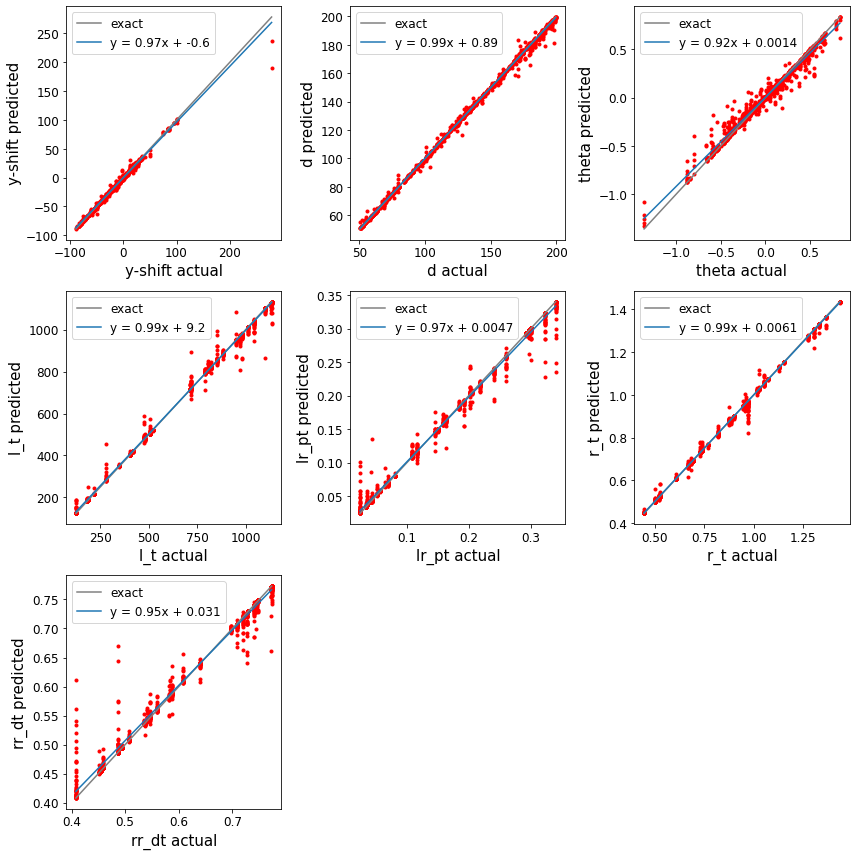

In [15]:
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

fig = plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:, i], output[:, i], c='red', marker='.')
    m, b = np.polyfit(y[:, i], output[:, i], 1)
    yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
    ax.plot(yl, yl, color='gray', label='exact')
    ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

### Feature importance

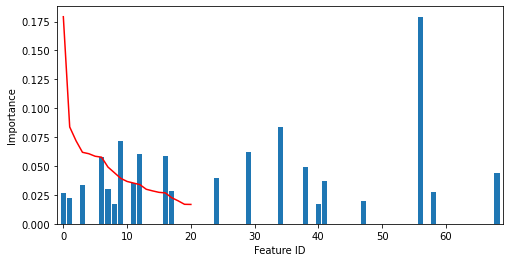

,id,importance,feature
0,56,0.179150,tr_l_w1
1,34,0.083773,pk_mean
2,9,0.071754,t_tr_std
3,29,0.061854,tr_mean
4,12,0.060625,t_tr_max_val
5,16,0.058426,t_pk_mean
6,6,0.057625,avg_min_idx_y
7,38,0.049079,pk_max_val
8,68,0.044238,tr_l_avg_mag
9,24,0.039331,stdev_mean


In [16]:
feat_red_df = pd.DataFrame({'id': top_feats, 'importance': model_red.feature_importances_,
                            'feature': summ_stats_names[top_feats]})
feat_red_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

plt.figure(figsize=(8, 4))
plt.bar(feat_red_df['id'], feat_red_df['importance'])
plt.plot(feat_red_df['importance'].values, 'r')
plt.xlim(-1, feat_red_df['id'].max()+ 1)
plt.xlabel('Feature ID')
plt.ylabel('Importance')
plt.show()

display(feat_red_df)